Abstract: This is a difficult regression task, where **the aim is to predict the burned area of forest fires, in the northeast region of Portugal**, by using meteorological and other data (see details at: [Web Link]).


**Source:**

Paulo Cortez, pcortez '@' dsi.uminho.pt, Department of Information Systems, University of Minho, Portugal.
Aníbal Morais, araimorais '@' gmail.com, Department of Information Systems, University of Minho, Portugal.


**Citation Request:**

This dataset is public available for research. The details are described in [Cortez and Morais, 2007].   
Please include this citation if you plan to use this database:   
[Cortez and Morais, 2007] P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. Available at: [Web Link]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('forestfires.csv')

In [3]:
df.columns = df.columns.str.lower()
df.head()

,x,y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


<BarContainer object of 517 artists>

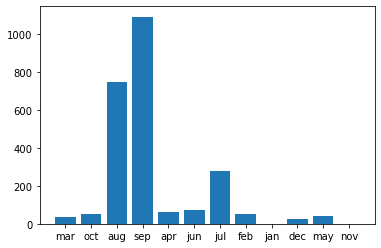

In [4]:
plt.bar(df.month, df.area) #Some basic plots

<BarContainer object of 517 artists>

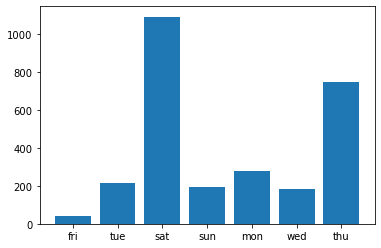

In [5]:
plt.bar(df.day, df.area)

(array([508.,   6.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.   ,  109.084,  218.168,  327.252,  436.336,  545.42 ,
         654.504,  763.588,  872.672,  981.756, 1090.84 ]),
 <BarContainer object of 10 artists>)

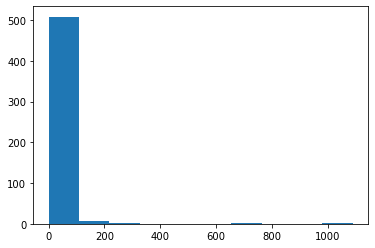

In [6]:
plt.hist(df.area) #Skewed response variable. log transform it

In [7]:
df.area = np.log1p(df.area)

In [8]:
df.describe()

,x,y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,1.111026
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,1.398436
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,2.024193
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620


### We now split dataset into train, test, val. This is so we can develop our model 

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.area.values
y_val = df_val.area.values
y_test = df_test.area.values

In [13]:
del df_train['area']
del df_val['area']
del df_test['area']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer

In [15]:
train_dict = df_train.to_dict(orient='records')

In [16]:
dv = DictVectorizer(sparse='False')
X_train = dv.fit_transform(train_dict)

In [17]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## 1. Using Decision Tree Regressor

In [18]:
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error

In [19]:
depths = [1, 2, 3, 5, 10, 15, 20, None]

for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=1)
                               # min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print('%4s -> %.3f' % (depth, rmse))
    
#Lowest rmse = depth of 1

   1 -> 1.342
   2 -> 1.380
   3 -> 1.469
   5 -> 1.674
  10 -> 2.069
  15 -> 2.125
  20 -> 2.131
None -> 2.131


In [20]:
scores = []

for depth in [1, 2, 3]:
    for s in [1, 5, 10, 15, 20, 50, 100]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append((depth, s, rmse))

In [21]:
columns = ['max_depth', 'min_samples_leaf', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [22]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse              
max_depth             1      2      3
min_samples_leaf                     
1                 1.342  1.380  1.469
5                 1.342  1.380  1.448
10                1.342  1.357  1.473
15                1.342  1.357  1.473
20                1.342  1.357  1.435
50                1.342  1.378  1.405
100               1.349  1.343  1.343

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

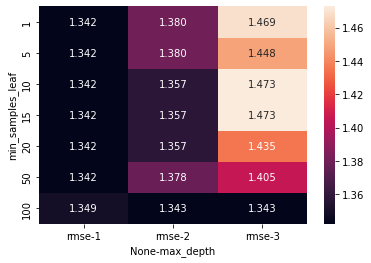

In [23]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

We will go with max_depth of 1 and min_sample_leaf of 20. min_sample_leaf of 20 was randomly chosen since we had all to be similar

In [24]:
dt = DecisionTreeRegressor(max_depth=1, min_samples_leaf=20)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, min_samples_leaf=20)

In [25]:
y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

1.3423421616364377

In [26]:
y_pred = dt.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

1.38342035930118

In [27]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- rh <= 34.50
|   |--- value: [1.47]
|--- rh >  34.50
|   |--- value: [0.97]



C:\Users\olait\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Using Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, rmse))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

(1.32, 1.38)

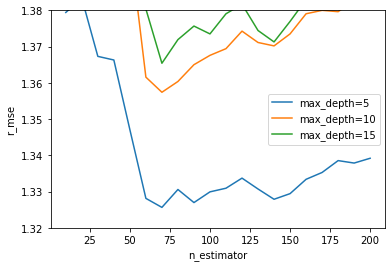

In [30]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.xlabel('n_estimator')
plt.ylabel('r_mse')
plt.legend()

plt.ylim([1.32, 1.38])

In [31]:
RandomForestRegressor(n_estimators=70, max_depth=15)

RandomForestRegressor(max_depth=15, n_estimators=70)

In [32]:
max_depth=15

In [33]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((s, n, rmse))

In [34]:
columns = ['min_samples_leaf', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

(1.31, 1.42)

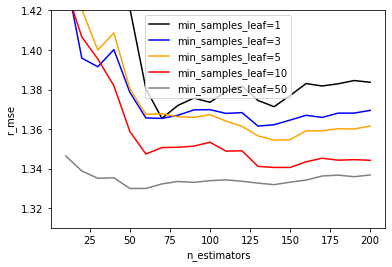

In [35]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.xlabel('n_estimators')
plt.ylabel('r_mse')
plt.legend()
plt.ylim([1.31, 1.42])

In [36]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, min_samples_leaf=50)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

1.3275422366481326

In [87]:
#rf.feature_importances_
df_importance = pd.DataFrame()
df_importance['features'] = dv.get_feature_names()
df_importance['importances'] = rf.feature_importances_

C:\Users\olait\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [93]:
df_importance.sort_values(by='importances', ascending=False).head()

,features,importances
24,rh,0.423751
25,temp,0.126844
26,wind,0.115909
8,dmc,0.093839
27,x,0.088452


## Using Gradient Boosting; XgBoost

In [37]:
import xgboost as xgb

In [38]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

C:\Users\olait\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [40]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [41]:
scores = {}

In [42]:
%%capture output

xgb_params = {
    'eta': 0.3, #manually change "eta" for several values eg; 0.01, 0.1, 0.5, 1.0
    'max_depth': 6, #manually change "max_depth" for several values eg; 2, 4, 6, 7, 10
    'min_child_weight': 1, #manually change "min_child_weight" for several values eg; 1. 2. 5, 10
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [43]:
# df_score = parse_xgb_output(output)

In [44]:
# key = 'eta=%s' % (xgb_params['eta'])
# scores[key] = parse_xgb_output(output)
# key

In [45]:
s = output.stdout #just checking what output looks like
print(s[:200])

[0]	train-rmse:1.31727	val-rmse:1.40059
[5]	train-rmse:0.87696	val-rmse:1.39632
[10]	train-rmse:0.64354	val-rmse:1.40499
[15]	train-rmse:0.52118	val-rmse:1.44011
[20]	train-rmse:0.42018	val-rmse:1.471


In [46]:
scores['eta=0.3'] = parse_xgb_output(output)

In [47]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [48]:
scores['eta=0.1'] = parse_xgb_output(output)

In [49]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [50]:
scores['eta=0.01'] = parse_xgb_output(output)

In [51]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1', 'eta=0.01'])

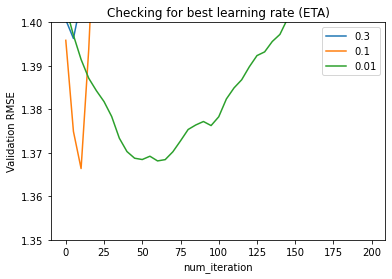

In [52]:
plt.plot(scores['eta=0.3']['num_iter'], scores['eta=0.3']['val_rmse'], label='0.3')
plt.plot(scores['eta=0.1']['num_iter'], scores['eta=0.1']['val_rmse'], label='0.1')
plt.plot(scores['eta=0.01']['num_iter'], scores['eta=0.01']['val_rmse'], label='0.01')

plt.ylim([1.35, 1.40])

plt.xlabel('num_iteration')
plt.ylabel('Validation RMSE')
plt.title('Checking for best learning rate (ETA)')
plt.legend() 

#We choose rmse of 0.01. Much more stable than 0.1

In [53]:
# scores = {}

In [54]:
# eta = [0.3, 0.1, 0.01]

In [55]:
# for rate in eta:

#     %%capture output ####****Magic function not working in for loop

#     xgb_params = {
#         'eta': rate, #manually change "eta" for several values eg; 0.01, 0.1, 0.5, 1.0
#         'max_depth': 6, ##manually change "max_depth" for several values eg; 2, 4, 6, 7, 10
#         'min_child_weight': 1, #manually change "min_hild_weight" for several values eg; 0.01, 0.1, 0.5, 1.0

#         'objective': 'reg:squarederror',
#         'eval_metric': 'rmse',

#         'nthread': 8,
#         'seed': 1,
#         'verbosity': 1,
#     }

#     model = xgb.train(xgb_params, dtrain, num_boost_round=200,
#                       verbose_eval=5,
#                       evals=watchlist)

#     key = 'eta=%s' % (xgb_params['eta'])
#     scores[key] = parse_xgb_output(output)
    
# #    parse_xgb_output(output)

### Find preferred depth. Choose between depths (1, 2, 3, 5, 10)

In [56]:
depth = {}

In [57]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 1, #manually change "max_depth" for several values eg; 2, 4, 6, 7, 10
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [58]:
depth['depth=1'] = parse_xgb_output(output)

In [59]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [60]:
depth['depth=2'] = parse_xgb_output(output)

In [61]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [62]:
depth['depth=3'] = parse_xgb_output(output)

In [63]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [64]:
depth['depth=5'] = parse_xgb_output(output)

In [65]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [66]:
depth['depth=10'] = parse_xgb_output(output)

In [67]:
depth.keys()

dict_keys(['depth=1', 'depth=2', 'depth=3', 'depth=5', 'depth=10'])

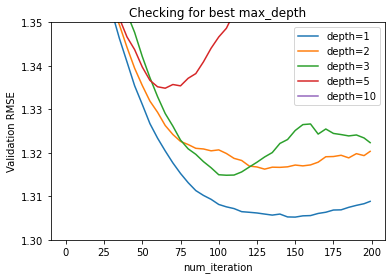

In [68]:
plt.plot(depth['depth=1']['num_iter'], depth['depth=1']['val_rmse'], label='depth=1')
plt.plot(depth['depth=2']['num_iter'], depth['depth=2']['val_rmse'], label='depth=2')
plt.plot(depth['depth=3']['num_iter'], depth['depth=3']['val_rmse'], label='depth=3')
plt.plot(depth['depth=5']['num_iter'], depth['depth=5']['val_rmse'], label='depth=5')
plt.plot(depth['depth=10']['num_iter'], depth['depth=10']['val_rmse'], label='depth=10')

plt.ylim([1.30, 1.350])

plt.xlabel('num_iteration')
plt.ylabel('Validation RMSE')
plt.title('Checking for best max_depth')
plt.legend() 

#We choose max_depth of 1

We do similar process to find preferred `min_child_weight`. We wont be doing this but will choose the default value of `1` and `n_estimator` of 150 .

In [69]:
#Final xgboost paramters
xgb_params = {
    'eta': 0.01, 
    'max_depth': 1,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=150)
#                   verbose_eval=5,
#                   evals=watchlist)

## Selecting the final model

We will be selecting our best model from the trio of `Decision Tree`, `Random Forest` and `xgboost`. Final models are below

1. Decision Tree

In [70]:
dt = DecisionTreeRegressor(max_depth=1, min_samples_leaf=20)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

1.3423421616364377

2. Random Forest

In [71]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, min_samples_leaf=50)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

1.3375341766190005

3. XGBoost

In [72]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 1,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=150)

In [73]:
y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

1.3054483227351141

Final model with the least RMSE is XGBoost with RMSE of `1.305`. We will then use this on the `df_full_train` dataset

In [74]:
df_full_train.head()

,x,y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
135,3,5,aug,sat,93.5,139.4,594.2,20.3,17.6,52,5.8,0.0,0.000000
218,4,5,sep,wed,92.9,133.3,699.6,9.2,19.4,19,1.3,0.0,3.487987
119,3,4,aug,thu,93.0,75.3,466.6,7.7,19.6,36,3.1,0.0,0.000000
463,6,5,feb,tue,75.1,4.4,16.2,1.9,4.6,82,6.3,0.0,1.854734
42,4,4,aug,tue,94.8,108.3,647.1,17.0,16.6,54,5.4,0.0,0.000000


In [76]:
df_full_train = df_full_train.reset_index(drop=True)

In [77]:
y_full_train = df_full_train.area.values

In [78]:
del df_full_train['area']

In [79]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [80]:
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [81]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

C:\Users\olait\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 1,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=150)

In [83]:
y_pred = model.predict(dtest)
np.sqrt(mean_squared_error(y_test, y_pred))

1.482018995387439